# State Farm Distracted Driver Detection
This notebook contains code for State Farm Distracted Driver Detection dataset chanllenge. Kaggle link: https://www.kaggle.com/c/state-farm-distracted-driver-detection

## Importing packages
Install and import necessary libraries

In [1]:
!pip install tqdm

    100% |################################| 81kB 3.2MB/s ta 0:00:01
You are using pip version 9.0.3, however version 21.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os
import shutil
import glob

import tqdm
import pandas as pd
import cv2
import caffe
import lmdb
import numpy as np
from sklearn.model_selection import train_test_split
from caffe.proto import caffe_pb2
from matplotlib import pyplot as plt

%matplotlib inline

## Preprocessing data
For large dataset we usually split the dataset into 3 subsets: training, validation and testing. We already have a individual test set for final evaluation. So we still need to split the original training set into a training and a validation set for parameters tuning.

As you know the dataset is already seperated into each class: one directory for images with label c0, another directory for images with label c1, etc. For loading the dataset thus we don't need the .csv file provided, we can go to the directories one by one and load the images, and for each image we record the parent directory name (c0, c1, ...) as the label for that image.

In [3]:
def prepare_data(data_dir, split=0.2):
    """Load raw data and split it into training and validation subset.
    
    Args
    :data_dir: Data root directory.
    
    Returns
    :X_train: A list of training image paths.
    :y_train: A list of training labels.
    :X_val: A list of validation image paths.
    :y_val: A list of validation labels.
    """
    imgs_list = []
    labels = []

    # List all image subdirectories and sort by class name
    img_dirs = sorted(glob.glob(os.path.join(data_dir, '*')), key = lambda k: k.split("/")[-1])
    for img_dir in img_dirs:
        # Read all the images in this class
        # Image subdirectory name as label
        for img_path in glob.glob(os.path.join(img_dir,'*.jpg')):
            imgs_list.append(img_path)
            labels.append(int(img_dir.split("/")[-1].replace('c', '')))
    
    # Split into training and validation subset
    X_train, X_test, y_train, y_test = train_test_split(imgs_list, labels, test_size = 0.2)
    
    return X_train, X_test, y_train, y_test

    #return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

## Get data
Here we use the function we just defined above to load data.

In [4]:
path_train_images = 'imgs/train'
path_test_images = 'imgs/test'

X_train, X_test, y_train, y_test = prepare_data(path_train_images)

print('Size of X_train: {}, size of y_train: {}'.format(len(X_train), len(y_train)))
print('Size of X_test: {}, size of y_test: {}'.format(len(X_test), len(y_test)))

Size of X_train: 11245, size of y_train: 11245
Size of X_test: 2812, size of y_test: 2812


## Data sanity check

Classes:
- c0: safe driving
- c1: texting - right
- c2: talking on the phone - right
- c3: texting - left
- c4: talking on the phone - left
- c5: operating the radio

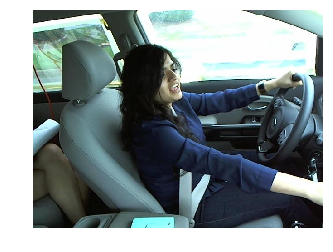

Class: 5


In [5]:
# Load an image
img = cv2.imread(X_train[65])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

# Check label
print('Class: {}'.format(y_train[65]))

## Caffe Overview
Caffe is a deep learning framework developed by the Berkeley Vision and Learning Center (BVLC). It is written in C++ and has Python and Matlab interfaces.

There are 4 steps in training a CNN using Caffe:

- Step 1 - Data preparation: In this step, we get the images and store them in a format that can be used by Caffe. Here we will write a Python script that will handle image storage.

- Step 2 - Model definition: In this step, we choose a CNN architecture and we define its parameters in a configuration file with extension .prototxt.

- Step 3 - Solver definition: The solver is responsible for model optimization. We define the solver parameters in a configuration file with extension .prototxt.

- Step 4 - Model training: We train the model by executing caffe command from the terminal. After training the model, we will get the trained model in a file with extension .caffemodel.

After the training phase, we will use the .caffemodel trained model to make predictions of new unseen data.

## Data preparation
Here we prepare the raw dataset as LMDB database, which is standard Caffe data format. We need some piece of Python code.

In [6]:
import lmdb
import caffe
from caffe.proto import caffe_pb2


def transform_img(img, img_width=224, img_height=224):
    """Resize image.
    
    Args
    :img: numpy array image.
    :img_width: Target image width.
    :img_height: Target image height.
    
    Returns
      resized image.
    """
    img = cv2.resize(img, (img_width, img_height), interpolation=cv2.INTER_CUBIC)

    return img


def make_datum(img, label):
    """
    Convert original numpy array image to datum
    Args
    :img: numpy.ndarray (BGR instead of RGB)
    :label: int
    """
    return caffe_pb2.Datum(
        channels=3,
        width=224,
        height=224,
        label=label,
        data=np.rollaxis(img, 2).tostring())


def make_lmdb(lmdb_path, x_data, y_data):
    """Create LMDB database from the given raw images and labels.
    
    Args
    :lmdb_path: LMDB output path.
    :x_data: A list of image paths.
    :y_data: A list of labels.
    """
    in_db = lmdb.open(lmdb_path, map_size=int(1e12))
    with in_db.begin(write=True) as in_txn:
        for in_idx, img_path in tqdm.tqdm(enumerate(x_data)):
            img = cv2.imread(img_path)
            img = transform_img(img)
            datum = make_datum(img, y_data[in_idx])  # Making datum object
            in_txn.put('{:0>5d}'.format(in_idx).encode('utf-8'), datum.SerializeToString())
    in_db.close()

In [7]:
# Actually create training and validation database
train_lmdb = 'input/train_lmdb'
val_lmdb = 'input/validation_lmdb'

os.makedirs(train_lmdb, exist_ok=True)
os.makedirs(val_lmdb, exist_ok=True)
make_lmdb(train_lmdb, X_train, y_train)
make_lmdb(val_lmdb, X_test, y_test)

11245it [02:00, 93.34it/s]
2812it [00:27, 102.50it/s]


### Links to articles that explain how to create a Neural network in Caffe

1. https://prateekvjoshi.com/2016/04/19/how-to-programmatically-create-a-deep-neural-network-in-python-caffe/
2. https://github.com/BVLC/caffe/wiki/Making-Prototxt-Nets-with-Python

## Create architecture
Caffe philosophy is expression, modularity and speed. For that we use text files to define networks, instead of code API like Keras. Coding is possible in Caffe too, but highly discoureged.

After deciding on the CNN architecture, we need to define its parameters in a .prototxt file. Here is the details of the defined network structure in my git repo.

### 1. Data Layer
Data enters Caffe through data layers: they lie at the bottom of nets. Data can come from efficient databases (LevelDB or LMDB), directly from memory, or, when efficiency is not critical, from files on disk in HDF5 or common image formats. Parameters we have in data layer:


### 2. Convolution layer
This layer recieves the data blob from last layer and produces conv1 blob. Convolution layers in neural networks generally convolve the input image with a set of learnable filters, each producing one feature map in the output image.


### 3. Pooling layer
We set the pool to max so it does max pooling operation on convolution outputs.

### 4. Dense layer
This layer is similar to previous layers too. Dense layers are knows as InnerProduct layers in Caffe.


### 5. ReLU layer
Since ReLU is element-wise we can do the operation once and not waste memory. This can be done with defining one name for top and bottom layers. Note that we can not have same names for blob of other layers and this is pecuilar for this layer.


### 6. Loss
We define loss function here.

## Caffe Solver
The solver is responsible for model optimization. We define the solver's parameters in a .prototxt file. 

This solver computes the accuracy of the model using the validation set every 100 iterations. The optimization process will run for a maximum of 300 iterations and will take a snapshot of the trained model every 50 iterations.

base_lr, lr_policy, gamma, momentum and weight_decay are hyperparameters that we need to tune to get a good convergence of the model.

I chose lr_policy: "step" with stepsize: 200, base_lr: 0.001 and gamma: 0.1. In this configuration, we will start with a learning rate of 0.001, and we will drop the learning rate by a factor of ten every 200 iterations.

There are different strategies for the optimization process. For a detailed explanation, you can read Caffe's solver documentation.
```
net: "caffe-cnn/cnn/cnn.prototxt"
test_iter: 88
test_interval: 100
base_lr: 0.001
lr_policy: "step"
gamma: 0.1
stepsize: 200
display: 50
max_iter: 300
momentum: 0.9
weight_decay: 0.0005
snapshot: 50
snapshot_prefix: "./snapshot/cnn"
solver_mode: CPU

```

## Training


In [8]:
#!mkdir -p ./snapshot/cnn
!caffe train --solver "caffe-cnn/cnn/cnn_solver.prototxt"

I0214 13:01:30.559741    71 upgrade_proto.cpp:1113] snapshot_prefix was a directory and is replaced to ./snapshot/cnn/cnn_solver
I0214 13:01:30.560308    71 caffe.cpp:197] Use CPU.
I0214 13:01:30.560601    71 solver.cpp:45] Initializing solver from parameters: 
test_iter: 88
test_interval: 100
base_lr: 0.001
display: 50
max_iter: 300
lr_policy: "step"
gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
stepsize: 200
snapshot: 50
snapshot_prefix: "./snapshot/cnn/cnn_solver"
solver_mode: CPU
net: "caffe-cnn/cnn/cnn.prototxt"
train_state {
  level: 0
  stage: ""
}
I0214 13:01:30.562157    71 solver.cpp:102] Creating training net from net file: caffe-cnn/cnn/cnn.prototxt
I0214 13:01:30.564800    71 net.cpp:294] The NetState phase (0) differed from the phase (1) specified by a rule in layer data
I0214 13:01:30.564857    71 net.cpp:294] The NetState phase (0) differed from the phase (1) specified by a rule in layer accuracy
I0214 13:01:30.564996    71 net.cpp:51] Initializing net from parameters: 

I0214 13:01:31.125753    71 net.cpp:122] Setting up fc5
I0214 13:01:31.125824    71 net.cpp:129] Top shape: 32 512 (16384)
I0214 13:01:31.125852    71 net.cpp:137] Memory required for data: 857473152
I0214 13:01:31.125882    71 layer_factory.hpp:77] Creating layer relu5
I0214 13:01:31.125912    71 net.cpp:84] Creating Layer relu5
I0214 13:01:31.125978    71 net.cpp:406] relu5 <- fc5
I0214 13:01:31.126009    71 net.cpp:367] relu5 -> fc5 (in-place)
I0214 13:01:31.126040    71 net.cpp:122] Setting up relu5
I0214 13:01:31.126068    71 net.cpp:129] Top shape: 32 512 (16384)
I0214 13:01:31.126093    71 net.cpp:137] Memory required for data: 857538688
I0214 13:01:31.126119    71 layer_factory.hpp:77] Creating layer drop5
I0214 13:01:31.126160    71 net.cpp:84] Creating Layer drop5
I0214 13:01:31.126178    71 net.cpp:406] drop5 <- fc5
I0214 13:01:31.126202    71 net.cpp:367] drop5 -> fc5 (in-place)
I0214 13:01:31.126247    71 net.cpp:122] Setting up drop5
I0214 13:01:31.126267    71 net.cpp:12

I0214 13:01:31.355820    71 net.cpp:122] Setting up fc5
I0214 13:01:31.355942    71 net.cpp:129] Top shape: 32 512 (16384)
I0214 13:01:31.355986    71 net.cpp:137] Memory required for data: 857473408
I0214 13:01:31.356024    71 layer_factory.hpp:77] Creating layer relu5
I0214 13:01:31.356050    71 net.cpp:84] Creating Layer relu5
I0214 13:01:31.356077    71 net.cpp:406] relu5 <- fc5
I0214 13:01:31.356107    71 net.cpp:367] relu5 -> fc5 (in-place)
I0214 13:01:31.356184    71 net.cpp:122] Setting up relu5
I0214 13:01:31.356210    71 net.cpp:129] Top shape: 32 512 (16384)
I0214 13:01:31.356237    71 net.cpp:137] Memory required for data: 857538944
I0214 13:01:31.356256    71 layer_factory.hpp:77] Creating layer drop5
I0214 13:01:31.356288    71 net.cpp:84] Creating Layer drop5
I0214 13:01:31.356312    71 net.cpp:406] drop5 <- fc5
I0214 13:01:31.356331    71 net.cpp:367] drop5 -> fc5 (in-place)
I0214 13:01:31.356360    71 net.cpp:122] Setting up drop5
I0214 13:01:31.356417    71 net.cpp:12

I0214 13:20:36.210832    71 sgd_solver.cpp:280] Snapshotting solver state to binary proto file ./snapshot/cnn/cnn_solver_iter_200.solverstate
I0214 13:20:38.391753    71 solver.cpp:351] Iteration 200, Testing net (#0)
I0214 13:23:00.468205    80 data_layer.cpp:73] Restarting data prefetching from start.
I0214 13:23:07.143447    71 solver.cpp:418]     Test net output #0: accuracy = 0.17081
I0214 13:23:07.143541    71 solver.cpp:418]     Test net output #1: loss = 1.85878 (* 1 = 1.85878 loss)
I0214 13:23:11.384974    71 solver.cpp:239] Iteration 200 (0.133183 iter/s, 375.423s/50 iters), loss = 1.75834
I0214 13:23:11.385071    71 solver.cpp:258]     Train net output #0: loss = 1.75834 (* 1 = 1.75834 loss)
I0214 13:23:11.385103    71 sgd_solver.cpp:112] Iteration 200, lr = 0.0001
I0214 13:26:47.042230    71 solver.cpp:468] Snapshotting to binary proto file ./snapshot/cnn/cnn_solver_iter_250.caffemodel
I0214 13:26:49.187366    71 sgd_solver.cpp:280] Snapshotting solver state to binary proto

During the training process, we need to monitor the loss and the model accuracy. We can stop the process at anytime by pressing stop button. Caffe will take a snapshot of the trained model every 50 iterations, and store them under `./snapshot/cnn` folder.

The snapshots have .caffemodel extension. For example, 50 iterations snapshot will be called: `cnn_iter_50.caffemodel`

## Prediction
We will use the trained model to make prediction on test data.

In [9]:
net = caffe.Net('caffe-cnn/cnn/cnn.prototxt',
                './snapshot/cnn/cnn_solver_iter_300.caffemodel', caffe.TEST)

In [10]:
out = net.forward()

In [11]:
acc, loss = out['accuracy'].copy(), out['loss'].copy()
print('Accuracy: {:.2f}% Loss: {:.4f}'.format(acc*100, loss))

Accuracy: 12.50% Loss: 1.8003


TypeError: unhashable type: 'numpy.ndarray'

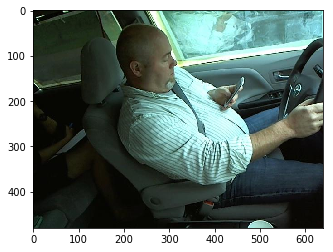

In [13]:
img_path = './imgs/test/img_197.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

res = net.forward({img})
#prob = res{1}

[[0.177947   0.1661464  0.1683369  0.15707242 0.1745001  0.15599719]]
0


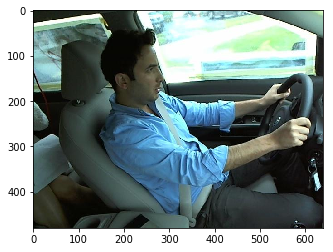

In [35]:
net = caffe.Classifier('caffe-cnn/cnn/cnn_single.prototxt',
                       './snapshot/cnn/cnn_solver_iter_300.caffemodel',
                       image_dims=(224, 224),
                       raw_scale=255)
img_path = './imgs/test/img_878.jpg'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

score = net.predict([caffe.io.load_image(img_path)])
print(score)
print(score.argmax())

In [25]:
def predict_on_single_image(net, img_path):
    """Return predicted class on a single image.
    
    Args
    :net: model instance.
    :img_path: Path to the image
    
    Returns
    :prob: The output probabilities of classes
    """
    input_shape = list(net.blobs['data'].shape)
    h, w = input_shape[-2:]
    img = caffe.io.load_image(img_path)
    img = cv2.resize(img, (w, h))
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, axis=0)
    net.blobs['data'].data[...] = img
    out = net.forward()
    pred = out['prob'] [0] # Single image
    return pred

Class: 0


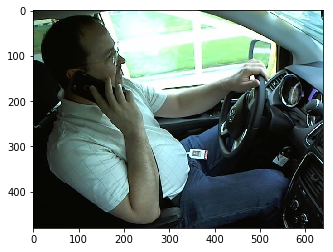

In [26]:
net = caffe.Net('caffe-cnn/cnn/cnn_single.prototxt',
                './snapshot/cnn/cnn_solver_iter_300.caffemodel', caffe.TEST)

img_path = './imgs/test/img_87.jpg'
pred = predict_on_single_image(net, img_path)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

print('Class:', np.argmax(pred))

In [27]:
pred

array([0.17794698, 0.1661464 , 0.16833691, 0.15707242, 0.17450008,
       0.1559972 ], dtype=float32)

## Transfer Learning
Caffe comes with a repository that is used by researchers and machine learning practitioners to share their trained models. This library is called Model Zoo.

Using this command we download the CaffeNet network structure, trained on ImageNet dataset.

In [8]:
!wget http://dl.caffe.berkeleyvision.org/bvlc_reference_caffenet.caffemodel

--2021-02-11 04:18:51--  http://dl.caffe.berkeleyvision.org/bvlc_reference_caffenet.caffemodel
Resolving dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)... 128.32.162.150
Connecting to dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)|128.32.162.150|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243862418 (233M) [application/octet-stream]
Saving to: 'bvlc_reference_caffenet.caffemodel'

bvlc_reference_caff 100%[===================>] 232.56M  1.70MB/s    in 3m 50s  

2021-02-11 04:22:41 (1.01 MB/s) - 'bvlc_reference_caffenet.caffemodel' saved [243862418/243862418]



In [16]:
!mkdir -p ./snapshot/caffenet

In [17]:
!caffe train --solver="caffe-cnn/caffenet/solver.prototxt" --weights "bvlc_reference_caffenet.caffemodel"

I0211 08:20:05.691992   373 upgrade_proto.cpp:1113] snapshot_prefix was a directory and is replaced to ./snapshot/caffenet/solver
I0211 08:20:05.692999   373 caffe.cpp:197] Use CPU.
I0211 08:20:05.693106   373 solver.cpp:45] Initializing solver from parameters: 
test_iter: 88
test_interval: 100
base_lr: 0.001
display: 50
max_iter: 200
lr_policy: "step"
gamma: 0.1
momentum: 0.9
weight_decay: 0.0005
stepsize: 100
snapshot: 50
snapshot_prefix: "./snapshot/caffenet/solver"
solver_mode: CPU
net: "caffe-cnn/caffenet/net.prototxt"
train_state {
  level: 0
  stage: ""
}
weights: "bvlc_reference_caffenet.caffemodel"
I0211 08:20:05.695083   373 solver.cpp:102] Creating training net from net file: caffe-cnn/caffenet/net.prototxt
I0211 08:20:05.697630   373 net.cpp:294] The NetState phase (0) differed from the phase (1) specified by a rule in layer data
I0211 08:20:05.697697   373 net.cpp:294] The NetState phase (0) differed from the phase (1) specified by a rule in layer accuracy
I0211 08:20:05.6

I0211 08:20:06.853472   373 net.cpp:122] Setting up conv3
I0211 08:20:06.853513   373 net.cpp:129] Top shape: 32 384 13 13 (2076672)
I0211 08:20:06.853525   373 net.cpp:137] Memory required for data: 176005248
I0211 08:20:06.853555   373 layer_factory.hpp:77] Creating layer relu3
I0211 08:20:06.853572   373 net.cpp:84] Creating Layer relu3
I0211 08:20:06.853585   373 net.cpp:406] relu3 <- conv3
I0211 08:20:06.853610   373 net.cpp:367] relu3 -> conv3 (in-place)
I0211 08:20:06.853623   373 net.cpp:122] Setting up relu3
I0211 08:20:06.853672   373 net.cpp:129] Top shape: 32 384 13 13 (2076672)
I0211 08:20:06.853691   373 net.cpp:137] Memory required for data: 184311936
I0211 08:20:06.853708   373 layer_factory.hpp:77] Creating layer conv4
I0211 08:20:06.853724   373 net.cpp:84] Creating Layer conv4
I0211 08:20:06.853741   373 net.cpp:406] conv4 <- conv3
I0211 08:20:06.853755   373 net.cpp:380] conv4 -> conv4
I0211 08:20:06.863505   373 net.cpp:122] Setting up conv4
I0211 08:20:06.863544  

I0211 08:20:08.557375   373 upgrade_proto.cpp:46] Attempting to upgrade input file specified using deprecated transformation parameters: bvlc_reference_caffenet.caffemodel
I0211 08:20:08.557406   373 upgrade_proto.cpp:49] Successfully upgraded file specified using deprecated data transformation parameters.
W0211 08:20:08.557443   373 upgrade_proto.cpp:51] Note that future Caffe releases will only support transform_param messages for transformation fields.
I0211 08:20:08.557735   373 upgrade_proto.cpp:55] Attempting to upgrade input file specified using deprecated V1LayerParameter: bvlc_reference_caffenet.caffemodel
I0211 08:20:08.759577   373 upgrade_proto.cpp:63] Successfully upgraded file specified using deprecated V1LayerParameter
I0211 08:20:08.821866   373 net.cpp:744] Ignoring source layer fc8
I0211 08:20:08.890749   373 solver.cpp:190] Creating test net (#0) specified by net file: caffe-cnn/caffenet/net.prototxt
I0211 08:20:08.890870   373 net.cpp:294] The NetState phase (1) dif

I0211 08:20:09.310218   373 net.cpp:122] Setting up fc6
I0211 08:20:09.310276   373 net.cpp:129] Top shape: 32 4096 (131072)
I0211 08:20:09.310297   373 net.cpp:137] Memory required for data: 213705088
I0211 08:20:09.310318   373 layer_factory.hpp:77] Creating layer relu6
I0211 08:20:09.310331   373 net.cpp:84] Creating Layer relu6
I0211 08:20:09.310346   373 net.cpp:406] relu6 <- fc6
I0211 08:20:09.310386   373 net.cpp:367] relu6 -> fc6 (in-place)
I0211 08:20:09.310410   373 net.cpp:122] Setting up relu6
I0211 08:20:09.310420   373 net.cpp:129] Top shape: 32 4096 (131072)
I0211 08:20:09.310434   373 net.cpp:137] Memory required for data: 214229376
I0211 08:20:09.310446   373 layer_factory.hpp:77] Creating layer drop6
I0211 08:20:09.310464   373 net.cpp:84] Creating Layer drop6
I0211 08:20:09.310477   373 net.cpp:406] drop6 <- fc6
I0211 08:20:09.310488   373 net.cpp:367] drop6 -> fc6 (in-place)
I0211 08:20:09.310499   373 net.cpp:122] Setting up drop6
I0211 08:20:09.310514   373 net.cp

I0211 08:20:10.737377   373 solver.cpp:351] Iteration 0, Testing net (#0)
I0211 08:22:16.590694   382 data_layer.cpp:73] Restarting data prefetching from start.
I0211 08:22:22.665004   373 solver.cpp:418]     Test net output #0: accuracy = 0.144886
I0211 08:22:22.665079   373 solver.cpp:418]     Test net output #1: loss = 1.91937 (* 1 = 1.91937 loss)
I0211 08:22:26.549731   373 solver.cpp:239] Iteration 0 (-1.4013e-45 iter/s, 135.901s/50 iters), loss = 2.10087
I0211 08:22:26.549908   373 solver.cpp:258]     Train net output #0: loss = 2.10087 (* 1 = 2.10087 loss)
I0211 08:22:26.549953   373 sgd_solver.cpp:112] Iteration 0, lr = 0.001
I0211 08:25:52.989327   373 solver.cpp:468] Snapshotting to binary proto file ./snapshot/caffenet/solver_iter_50.caffemodel
I0211 08:25:58.506417   373 sgd_solver.cpp:280] Snapshotting solver state to binary proto file ./snapshot/caffenet/solver_iter_50.solverstate
I0211 08:26:08.710048   373 solver.cpp:239] Iteration 50 (0.225063 iter/s, 222.16s/50 iters)

Test this transfer learning model

In [18]:
import caffe

net = caffe.Net('caffe-cnn/caffenet/net.prototxt',
                './snapshot/caffenet/solver_iter_200.caffemodel', caffe.TEST)

In [19]:
out = net.forward()

In [20]:
acc, loss = out['accuracy'].copy(), out['loss'].copy()
print('Accuracy: {:.2f}% Loss: {:.4f}'.format(acc*100, loss))

Accuracy: 96.88% Loss: 0.0855


Class: 4


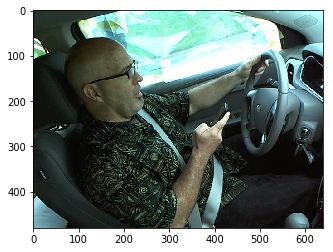

In [29]:
net = caffe.Net('caffe-cnn/caffenet/net_deploy.prototxt',
                './snapshot/caffenet/solver_iter_200.caffemodel', caffe.TEST)

img_path = './imgs/test/img_1537.jpg'
pred = predict_on_single_image(net, img_path)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

print('Class:', np.argmax(pred))

In [30]:
pred

array([0.16610667, 0.16586901, 0.16649374, 0.16555855, 0.16833243,
       0.16763952], dtype=float32)